In [68]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7

In [67]:
import numpy as np 
import pandas as pd 
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.layers import Dense, Dropout, LSTM 
from keras.models import Sequential

In [99]:
start = '1990-01-01'
end = '2021-11-30'
df = data.DataReader('AAPL', 'yahoo', start, end)
df.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,0.334821,0.312500,0.314732,0.332589,183198400.0,0.266423
1990-01-03,0.339286,0.334821,0.339286,0.334821,207995200.0,0.268211
1990-01-04,0.345982,0.332589,0.341518,0.335938,221513600.0,0.269106


In [100]:
df.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-26,160.449997,156.360001,159.570007,156.809998,76959800.0,156.809998
2021-11-29,161.190002,158.789993,159.369995,160.240005,88748200.0,160.240005
2021-11-30,165.520004,159.919998,159.990005,165.300003,174048100.0,165.300003


In [101]:
df = df.reset_index()
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

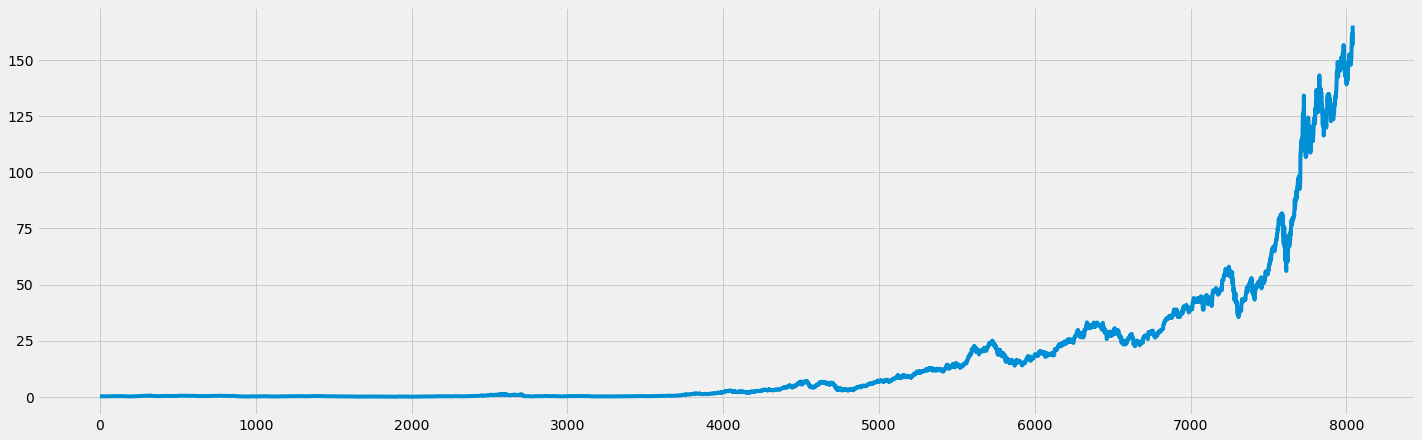

In [102]:
df = df.drop(['Date', 'Adj Close'], axis=1)
plt.plot(df.Close);

In [103]:
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()
ma100

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
8037    147.9696
8038    148.1688
8039    148.2912
8040    148.4612
8041    148.6631
Name: Close, Length: 8042, dtype: float64

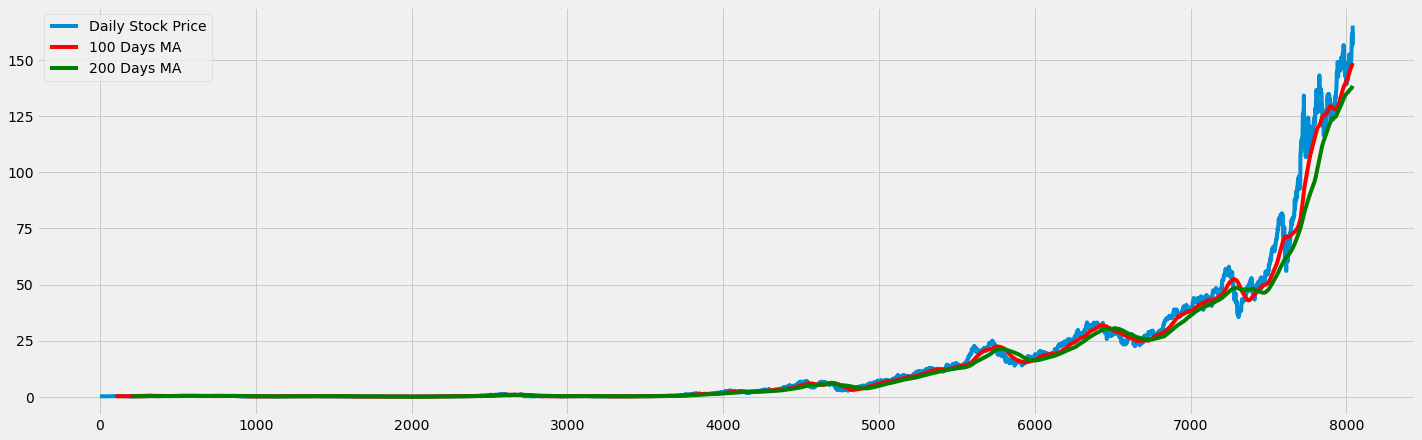

In [104]:
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.legend(['Daily Stock Price', '100 Days MA', '200 Days MA']);

In [105]:
df.shape

(8042, 5)

In [106]:
data_training = pd.DataFrame(df.Close[0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df.Close[int(len(df)*0.70):int(len(df))])
print(data_training.shape, data_testing.shape)

(5629, 1) (2413, 1)


In [107]:
data_training.head()

,Close
0,0.332589
1,0.334821
2,0.335938
3,0.337054
4,0.339286


In [108]:
data_testing.head()

,Close
5629,20.790358
5630,20.927856
5631,20.779285
5632,20.187500
5633,20.338572


In [109]:
scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.00960216],
       [0.00970089],
       [0.0097503 ],
       ...,
       [0.9549286 ],
       [0.94750355],
       [0.91745597]])

In [110]:
X_train = []
y_train = []
for i in range(200, data_training.shape[0]):
    X_train.append(data_training_array[i-200:i])
    y_train.append(data_training_array[i, 0]) #ith row and first column would be "y" for every record

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)
X_train

(5429, 200, 1) (5429,)


array([[[0.00960216],
        [0.00970089],
        [0.0097503 ],
        ...,
        [0.00585018],
        [0.00604764],
        [0.00585018]],

       [[0.00970089],
        [0.0097503 ],
        [0.00979967],
        ...,
        [0.00604764],
        [0.00585018],
        [0.00476406]],

       [[0.0097503 ],
        [0.00979967],
        [0.0098984 ],
        ...,
        [0.00585018],
        [0.00476406],
        [0.00535649]],

       ...,

       [[0.55374103],
        [0.56048674],
        [0.56009176],
        ...,
        [0.89805613],
        [0.88001499],
        [0.95856207]],

       [[0.56048674],
        [0.56009176],
        [0.57138725],
        ...,
        [0.88001499],
        [0.95856207],
        [0.9549286 ]],

       [[0.56009176],
        [0.57138725],
        [0.5854158 ],
        ...,
        [0.95856207],
        [0.9549286 ],
        [0.94750355]]])

In [111]:
model = Sequential()
model.add(LSTM(units=50, activation = 'relu', return_sequences = True,
              input_shape= (X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation = 'relu'))
model.add(Dropout(0.5))
        
model.add(Dense(units=1))

In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200, 50)           10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 60)           26640     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 60)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 200, 80)           45120     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 80)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 120)              

In [113]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
170/170 [==============================] - 66s 371ms/step - loss: 0.0046
Epoch 2/50
170/170 [==============================] - 66s 390ms/step - loss: 0.0015
Epoch 3/50
170/170 [==============================] - 67s 392ms/step - loss: 0.0016
Epoch 4/50
170/170 [==============================] - 67s 392ms/step - loss: 0.0014
Epoch 5/50
170/170 [==============================] - 67s 397ms/step - loss: 0.0014
Epoch 6/50
170/170 [==============================] - 68s 402ms/step - loss: 0.0014
Epoch 7/50
170/170 [==============================] - 68s 399ms/step - loss: 0.0013
Epoch 8/50
170/170 [==============================] - 68s 401ms/step - loss: 0.0013
Epoch 9/50
170/170 [==============================] - 67s 395ms/step - loss: 0.0014
Epoch 10/50
170/170 [==============================] - 74s 434ms/step - loss: 0.0013
Epoch 11/50
170/170 [==============================] - 84s 497ms/step - loss: 0.0012
Epoch 12/50
170/170 [==============================] - 84s 491ms/step - lo

In [45]:
model.save('keras_model.h5')

In [114]:
data_testing

,Close
5629,20.790358
5630,20.927856
5631,20.779285
5632,20.187500
5633,20.338572
...,...
8037,161.410004
8038,161.940002
8039,156.809998
8040,160.240005


In [115]:
data_training.tail(200)

,Close
5429,13.032857
5430,13.350000
5431,13.458929
5432,13.817857
5433,13.831786
...,...
5624,20.010000
5625,21.785713
5626,21.703571
5627,21.535713


In [116]:
## Prediction 
past_200_days = data_training.tail(200)
final_df = past_200_days.append(data_testing, ignore_index=True)
final_df

,Close
0,13.032857
1,13.350000
2,13.458929
3,13.817857
4,13.831786
...,...
2608,161.410004
2609,161.940002
2610,156.809998
2611,160.240005


In [117]:
input_data = scaler.fit_transform(final_df)
print(input_data.shape)
input_data

(2613, 1)


array([[0.00273906],
       [0.00481616],
       [0.00552958],
       ...,
       [0.94439542],
       [0.96685997],
       [1.        ]])

In [118]:
input_data.shape

(2613, 1)

In [119]:
X_test = []
y_test = []
for i in range(200, input_data.shape[0]):
    X_test.append(input_data[i-200:i])
    y_test.append(input_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((2413, 200, 1), (2413,))

In [120]:
y_predicted = model.predict(X_test)
print(y_predicted.shape)
print(y_test.shape)

(2413, 1)
(2413,)


In [121]:
scaler.scale_

array([0.00654942])

In [122]:
scale_factor = 1/scaler.scale_
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor
y_predicted

array([[ 15.51259349],
       [ 15.45773185],
       [ 15.40262677],
       ...,
       [133.3091028 ],
       [134.25734704],
       [135.12314752]])

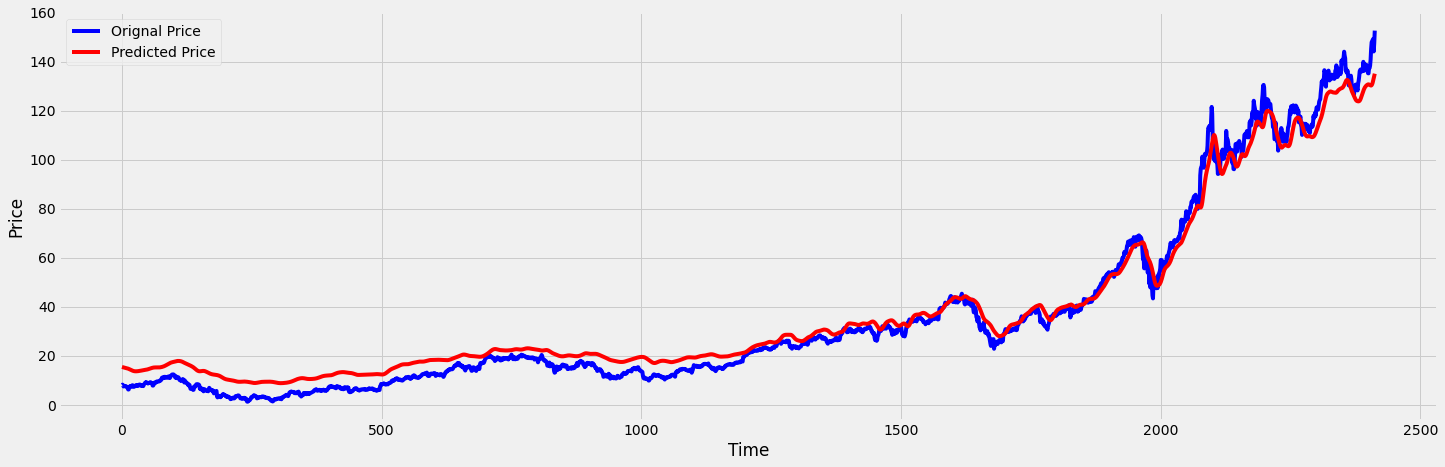

In [123]:
plt.plot(y_test, 'b', label = 'Orignal Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend();

In [124]:
mean_absolute_error(y_test, y_predicted)

4.527854319720494

In [125]:
r2_score(y_test, y_predicted)

0.9801392583661875